In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

# Multivariate GRU

**Changes**:

* More layers
* More units
* More features

In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Dataset

In [152]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

from config import processed_data_dir

dataset_version = 'v4'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)

train_features_df.head()

,farm_id,time,ndvi_mean,ndvi_median,cvi_mean,cvi_median,evi_mean,evi_median,arvi2_mean,arvi2_median,...,band_7_median,band_8_mean,band_8_median,band_8a_mean,band_8a_median,band_11_mean,band_11_median,band_12_mean,band_12_median,y
0,1,2017-01-01,0.671766,0.692653,inf,0.947159,2.474928,0.0,0.605966,0.630404,...,0.0,1774.600000,0.0,1945.271429,0.0,986.121429,0.0,496.128571,0.0,Vineyard
1,1,2017-01-31,0.718396,0.729027,inf,1.052384,2.208423,0.0,0.660523,0.672961,...,0.0,1878.164286,0.0,1941.592857,0.0,992.671429,0.0,521.650000,0.0,Vineyard
2,1,2017-02-10,0.746055,0.755768,1.977070,1.065654,2.510243,0.0,0.692884,0.704249,...,0.0,2199.185714,0.0,2474.121429,0.0,1106.557143,0.0,508.700000,0.0,Vineyard
3,1,2017-03-12,0.668629,0.684211,2.180335,0.865489,3.435664,0.0,0.602296,0.620526,...,0.0,1573.342857,0.0,1719.757143,0.0,898.800000,0.0,466.950000,0.0,Vineyard
4,1,2017-03-22,0.659258,0.673052,2.783775,1.226074,4.197762,0.0,0.591332,0.607470,...,0.0,1549.492857,0.0,1729.335714,0.0,871.714286,0.0,433.728571,0.0,Vineyard


### Imput missing values

In [153]:
def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
    for ts, ts_df in df.groupby('time'):
        df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df
        
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)

train_features_df.head()

,farm_id,time,ndvi_mean,ndvi_median,cvi_mean,cvi_median,evi_mean,evi_median,arvi2_mean,arvi2_median,...,band_7_median,band_8_mean,band_8_median,band_8a_mean,band_8a_median,band_11_mean,band_11_median,band_12_mean,band_12_median,y
0,1,2017-01-01,0.671766,0.692653,3.001651,0.947159,2.474928,0.0,0.605966,0.630404,...,0.0,1774.600000,0.0,1945.271429,0.0,986.121429,0.0,496.128571,0.0,Vineyard
1,1,2017-01-31,0.718396,0.729027,2.744553,1.052384,2.208423,0.0,0.660523,0.672961,...,0.0,1878.164286,0.0,1941.592857,0.0,992.671429,0.0,521.650000,0.0,Vineyard
2,1,2017-02-10,0.746055,0.755768,1.977070,1.065654,2.510243,0.0,0.692884,0.704249,...,0.0,2199.185714,0.0,2474.121429,0.0,1106.557143,0.0,508.700000,0.0,Vineyard
3,1,2017-03-12,0.668629,0.684211,2.180335,0.865489,3.435664,0.0,0.602296,0.620526,...,0.0,1573.342857,0.0,1719.757143,0.0,898.800000,0.0,466.950000,0.0,Vineyard
4,1,2017-03-22,0.659258,0.673052,2.783775,1.226074,4.197762,0.0,0.591332,0.607470,...,0.0,1549.492857,0.0,1729.335714,0.0,871.714286,0.0,433.728571,0.0,Vineyard


In [154]:
train_features_df.describe()

,farm_id,ndvi_mean,ndvi_median,cvi_mean,cvi_median,evi_mean,evi_median,arvi2_mean,arvi2_median,datt1_mean,...,band_7_mean,band_7_median,band_8_mean,band_8_median,band_8a_mean,band_8a_median,band_11_mean,band_11_median,band_12_mean,band_12_median
count,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,...,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000,27434.000000
mean,1814.447073,0.450196,0.449532,3.129516,1.013927,2.382699,0.924465,0.346730,0.345953,1.994397,...,1279.818918,871.218470,1261.421054,848.573012,1411.921117,961.769392,1022.854193,697.416162,625.459387,409.366297
std,1044.548200,0.452220,0.535394,1.401391,0.312188,8.000046,2.615713,0.529098,0.626411,34.667312,...,544.467131,1280.844412,531.408163,1248.794559,585.325603,1407.548210,372.120636,1001.944129,291.442709,631.176083
min,1.000000,0.053159,0.031391,0.121644,0.121644,-237.326350,-24.429708,-0.117804,-0.143272,0.367741,...,104.615385,0.000000,93.395604,0.000000,112.373626,0.000000,101.694828,0.000000,50.629310,0.000000
25%,910.000000,0.240155,0.232453,2.566669,0.944107,0.442345,0.000000,0.100982,0.091971,0.747486,...,894.187500,0.000000,885.908375,0.000000,995.851905,0.000000,774.899484,0.000000,409.443858,0.000000
50%,1812.500000,0.440965,0.442006,2.945603,1.001089,1.436137,0.000000,0.335929,0.337147,0.793704,...,1197.037023,0.000000,1185.832374,0.000000,1333.345139,0.000000,983.028509,0.000000,569.657181,0.000000
75%,2746.000000,0.635379,0.651626,3.248187,1.062343,3.657401,0.427369,0.563393,0.582403,0.837678,...,1585.526103,2004.875000,1562.200670,1968.000000,1743.471804,2256.000000,1234.650501,1724.500000,792.109711,807.000000
max,3603.000000,39.409713,64.187071,40.883039,37.079810,177.472151,31.257624,45.929364,74.918874,3592.191825,...,4139.241935,5596.500000,3854.875806,5216.500000,4369.925806,5941.000000,3242.969231,4165.000000,2641.457692,3310.500000


In [155]:
test_features_df.head()

,farm_id,time,ndvi_mean,ndvi_median,cvi_mean,cvi_median,evi_mean,evi_median,arvi2_mean,arvi2_median,...,band_7_mean,band_7_median,band_8_mean,band_8_median,band_8a_mean,band_8a_median,band_11_mean,band_11_median,band_12_mean,band_12_median
0,5,2017-01-01,0.689752,0.731648,2.068338,1.119381,2.161075,0.0,0.627010,0.676028,...,912.050725,0.0,879.932367,0.0,1002.871981,0.0,455.743961,0.0,222.449275,0.0
1,5,2017-01-31,0.773126,0.808656,1.897484,0.834228,1.935097,0.0,0.724557,0.766128,...,918.654589,0.0,936.635266,0.0,998.741546,0.0,419.282609,0.0,208.004831,0.0
2,5,2017-02-10,0.774520,0.797879,1.966353,0.772374,1.705933,0.0,0.726189,0.753518,...,1222.502415,0.0,1160.724638,0.0,1359.101449,0.0,541.028986,0.0,233.345411,0.0
3,5,2017-03-12,0.720137,0.754934,2.229678,1.138888,7.618985,0.0,0.662560,0.703273,...,797.555556,0.0,802.357488,0.0,897.886473,0.0,431.502415,0.0,211.504831,0.0
4,5,2017-03-22,0.613666,0.632955,1.653267,0.833685,2.309882,0.0,0.537989,0.560557,...,728.065217,0.0,731.794686,0.0,847.780193,0.0,467.217391,0.0,228.253623,0.0


## Normalize Features Dataset

Neural Nets are sensitive to scale, but we want to keep the variance in the features. So we will MinMax scale each feature on a specific time step over all farms. 

I.e - the network will see any number of variables at a time, but all of them will be on the same scale (0 - 1) and the variance between farms will be kept the same. 

In [156]:
# Make copies to compare before / after normalization
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()

In [157]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

times = train_features_df['time'].unique()
feature_cols = [col for col in test_features_df.columns if col not in ['farm_id','time']]

for ts in times:
    scaler = StandardScaler()
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.fit_transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])

## Transform Dataset for MVTS Classification

In [158]:
def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes
    

In [159]:
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (2494, 11, 34)
Test data:		 (1074, 11, 34)


In [160]:
test_features_df.head(11)

,farm_id,time,ndvi_mean,ndvi_median,cvi_mean,cvi_median,evi_mean,evi_median,arvi2_mean,arvi2_median,...,band_7_mean,band_7_median,band_8_mean,band_8_median,band_8a_mean,band_8a_median,band_11_mean,band_11_median,band_12_mean,band_12_median
0,5,2017-01-01,0.934584,1.040139,-0.855922,0.827375,-0.103433,-0.508431,0.934584,1.040139,...,-1.076256,-0.699001,-1.047527,-0.696152,-1.077414,-0.699417,-1.555647,-0.698523,-1.316424,-0.644145
1,5,2017-01-31,0.958399,1.058548,-0.704432,-0.380853,-0.294645,-0.587311,0.958399,1.058548,...,-1.156857,-0.707974,-1.109078,-0.705746,-1.153249,-0.708867,-1.523440,-0.700869,-1.316450,-0.657674
2,5,2017-02-10,0.853515,0.975023,-0.631042,-0.340280,-0.283331,-0.483158,0.853515,0.975023,...,-0.669716,-0.699926,-0.651029,-0.697032,-0.629856,-0.700826,-1.060795,-0.689595,-0.933895,-0.628692
3,5,2017-03-12,1.050426,1.176940,-0.628832,0.416531,0.258834,-0.415968,1.050426,1.176940,...,-1.202981,-0.708799,-1.160754,-0.707681,-1.194766,-0.710519,-1.410209,-0.698203,-1.244974,-0.659437
4,5,2017-03-22,0.479592,0.530700,-0.869733,-1.161328,-0.124687,-0.355363,0.479592,0.530700,...,-1.256470,-0.705420,-1.206626,-0.704288,-1.217531,-0.707704,-1.390490,-0.704323,-1.259133,-0.672856
5,5,2017-05-31,0.358630,0.369820,-0.318639,0.831300,0.010884,-0.137474,0.358630,0.369820,...,-1.012933,-0.679696,-1.032156,-0.675305,-1.023051,-0.684387,-1.340223,-0.708260,-1.226793,-0.683121
6,5,2017-06-20,0.183019,0.295335,-1.019531,-0.792059,0.104895,-0.322810,0.183019,0.295335,...,-1.166898,-0.684607,-1.185174,-0.679751,-1.157311,-0.687737,-1.501420,-0.707545,-1.416351,-0.687355
7,5,2017-07-10,0.063523,0.311542,0.141012,-0.247812,1.153922,-0.165337,0.063523,0.311542,...,-1.146417,-0.685934,-1.161552,-0.680370,-1.130089,-0.687266,-1.397464,-0.707329,-1.295554,-0.686251
8,5,2017-07-15,0.013592,0.019472,1.520874,0.170412,-0.098108,-0.333553,0.013592,0.019472,...,-1.087616,-0.676512,-1.097981,-0.669794,-1.073498,-0.679338,-1.330930,-0.702963,-1.229658,-0.678323
9,5,2017-08-04,-0.124783,-0.110993,-0.240705,1.389598,-0.379961,-0.311903,-0.124783,-0.110993,...,-1.187139,-0.676254,-1.194733,-0.670073,-1.201974,-0.677478,-1.328775,-0.695217,-1.144807,-0.667034


## Start Modelling Process

### Create validation set

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())
train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, train_labels, stratify=train_labels, test_size=0.2)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

print('train data : ',train_data.shape)
print('val data : ',val_data.shape)

train data :  (1995, 11, 34)
val data :  (499, 11, 34)


### Create model

In [166]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from src.visualization.tf_viz import PlotLosses

es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=50, verbose=1)

class_weight = 1-train_features_df.y.value_counts(normalize=True)

plot_losses = PlotLosses()

# def get_model(n_features):

#     model = models.Sequential()
#     model.add(layers.GRU(2, input_shape=(11, n_features), return_sequences=True, dropout=0.2, kernel_regularizer=keras.regularizers.l2(0.02)))
#     model.add(layers.GRU(4, dropout=0.1, return_sequences=True))
#     model.add(layers.GRU(6, dropout=0.05))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(18 ,activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
#     model.add(layers.Dense(9, activation='softmax'))
    
#     return model

def get_model(n_features):

    model = models.Sequential()
    model.add(layers.GRU(8, input_shape=(11, n_features), dropout=0.2, kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(layers.Flatten())
#     model.add(layers.Dense(18 ,activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(layers.Dense(9, activation='softmax'))
    
    return model



model = get_model(train_data.shape[-1])
# optimizer = keras.optimizers.Adam(learning_rate=0.003)
optimizer = keras.optimizers.RMSprop()
# optimizer = keras.optimizers.Nadam()
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])



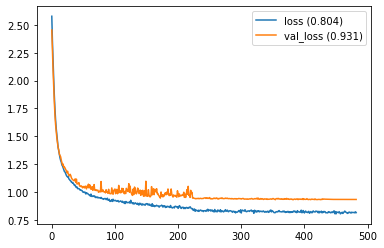


Epoch 00483: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1995/1995 - 0s - loss: 0.8154 - sparse_categorical_crossentropy: 0.7909 - val_loss: 0.9336 - val_sparse_categorical_crossentropy: 0.9092
Epoch 00483: early stopping


In [167]:
model.fit(train_data, 
          train_labels_enc,
          batch_size=64,
          validation_data=(val_data, val_labels_enc), 
          class_weight=class_weight,
          verbose=2,
          epochs=2000, 
          workers=4, 
          use_multiprocessing=True,
          callbacks=[plot_losses, es, reduce_lr])

In [145]:
from sklearn.metrics import log_loss

val_preds = model.predict(val_data)
train_preds = model.predict(train_data)
print('val loss: ',log_loss(val_labels_enc, val_preds))
print('train loss: ',log_loss(train_labels_enc, train_preds))

val loss:  0.8511081807584108
train loss:  0.7893250381793444


### Confusion matrix

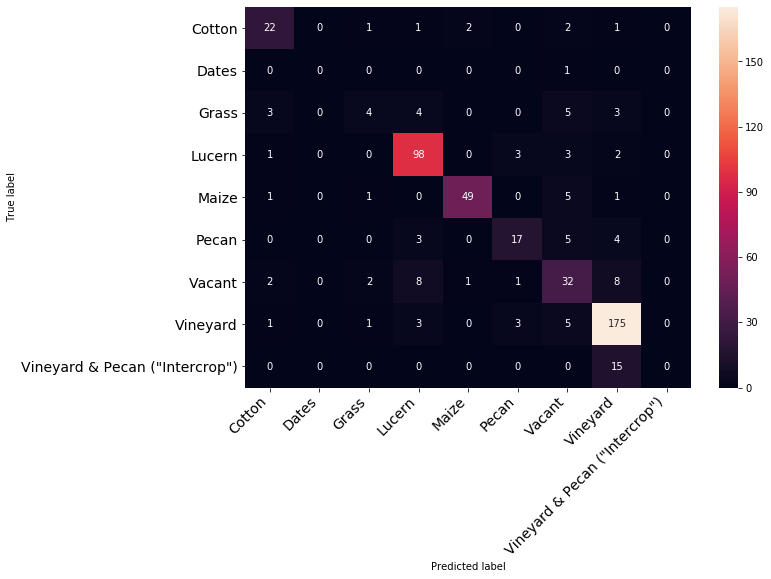

In [121]:
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_preds = model.predict_classes(val_data)

cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

## Make Submission

### First retrain on all data


In [122]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

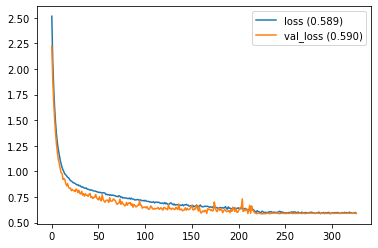


Epoch 00327: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
2244/2244 - 0s - loss: 0.5892 - sparse_categorical_crossentropy: 0.6045 - val_loss: 0.5903 - val_sparse_categorical_crossentropy: 0.6065
Epoch 00327: early stopping


In [124]:
model = get_model(all_data.shape[-1])
optimizer = keras.optimizers.RMSprop()
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(all_data, 
          all_labels,
          batch_size=64, 
          validation_split=0.1,
          class_weight=class_weight,
          verbose=2,
          epochs=350, 
          workers=4, 
          use_multiprocessing=True,
          callbacks=[plot_losses, es, reduce_lr])

In [125]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict(test_data)
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.007452,0.000222,0.012599,0.002219,0.000490,0.063126,0.004658,0.743041,0.166194
6,0.001993,0.000046,0.004435,0.001391,0.000329,0.017963,0.003458,0.840384,0.130002
10,0.000861,0.000022,0.001455,0.001120,0.000028,0.003784,0.001217,0.897946,0.093566
18,0.000571,0.000063,0.001528,0.000871,0.000008,0.006601,0.002455,0.912370,0.075533
23,0.000437,0.000087,0.002004,0.002341,0.000013,0.010393,0.003165,0.916919,0.064640


In [126]:
from config import subs_dir

sub_df.to_csv(subs_dir / 'gru_vi_v3_1.csv')